In [516]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings

## All you need is love… And a dog!
Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not. You will be working with the following features:

- animal_type: Type of animal. May be one of 'cat', 'dog', 'bird', etc.
- intake_year: Year of intake
- intake_condition: The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
- intake_number: The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
- intake_type: The type of intake, for example, 'stray', 'owner surrender', etc.
- sex_upon_intake: The gender of the animal and if it has been spayed or neutered at the time of intake
- age_upon_intake_(years): The age of the animal upon intake represented in years
- time_in_shelter_days: Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
- sex_upon_outcome: The gender of the animal and if it has been spayed or neutered at time of outcome
- age_upon_outcome_(years): The age of the animal upon outcome represented in years
- outcome_type: The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.


A) Load the dataset and perform the necesssary preprossessing. Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1.

B) Train a random forest. Use 3-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, the train and test accuracies, and the 10 most important features.

In [517]:
df = pd.read_csv('aac_intakes_outcomes.csv')

# Preprocessing

In [518]:
#We first limit the dataframe to the 10 above mentioned features

cols = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake',
        'age_upon_intake_(years)', 'outcome_type']

df_clean = df[cols]

except for the 'outcome type' feature, which is the one we are trying to predict, I am leaving out the other outcome 
related features, as in my opinion, it makes no logical sense to keep them in. think about it in this way - if we the try
to predict the outcome, how are we supposed know the age at the time of the outcome before we know the actual outcome
itself? I see the application of this model in a scenario in which the animal is taken in and then based on the intake 
features, we predict the outcome. at this point, none of the outcome features in this data set will be available and thus 
i decide to leave them out.

In [519]:
# let's next check which of the features contains nan values
df_clean.isnull().sum()

animal_type                 0
intake_year                 0
intake_condition            0
intake_number               0
intake_type                 0
sex_upon_intake             1
age_upon_intake_(years)     0
outcome_type               10
dtype: int64

In [520]:
def nullremover(df, thres1, thres2, target):
    len_before = len(df)
    print ('number of rows before:', len_before)
    for col in list(df.columns):
        if df[col].isnull().sum()/(len(df)) <= thres2:
            df = df.dropna()
        else:
            pass
        if col != target:
            if df[col].isnull().sum()/(len(df)) >= thres1:
                df.drop([col], axis=1, inplace=True)
            else:
                pass
    len_after = len(df)
    print ('Percentage of missing values for columns')
    print((df.isnull().sum()/len(df)*100))
    print ('number of rows after:',len_after)
    print('number of rows removed:', len_before-len_after)
    return df

In [521]:
df_nonull = nullremover(df_clean, 0.9, 0.2, 'outcome_type')

number of rows before: 79672
Percentage of missing values for columns
animal_type                0.0
intake_year                0.0
intake_condition           0.0
intake_number              0.0
intake_type                0.0
sex_upon_intake            0.0
age_upon_intake_(years)    0.0
outcome_type               0.0
dtype: float64
number of rows after: 79661
number of rows removed: 11


I then write a function that contains 2 thresholds. The first threshold is the percentage of nan values in a column. if the percentage of nan values in a specific column is equal to/higher than the threshold, the entire column gets removed as it is of little use due to its high amount of nan values. the second threshold is also the percentage of nan values in a column. in this case, though, if the percentage of nan values in a specific column is equal to/lower than the threshold, the specific rows with nan values get dropped.

In case the percentage of nan values is somewhere in between the 2 thresholds, one should apply some more advanced imputation methods. In this case this is not needed as all nan values have been dealt with by the previously described method.

In [522]:
transout = []
for row in df_nonull['outcome_type'].iteritems():
    if row[1] == 'Adoption':
        transout.append(1)
    else:
        transout.append(0)

df_nonull.drop('outcome_type', axis=1, inplace=True)
df_nonull['outcome_type'] = transout

We next transform our target feature into the desired format by iterating over the rows and appending the value 1 to a list, whenever the outcome type is "Adoption" and 0 when it isn't. Then we append this list to our dataframe as a column.

In [523]:
X_train, X_test, y_train, y_test = train_test_split(df_nonull.drop('outcome_type', axis=1), df_nonull['outcome_type'], test_size=0.175, random_state=42, 
                                                    stratify=df_nonull['outcome_type'])

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [524]:
def isolation_outlier(df):
    print('dataset with outliers:', len(df))
    isof = IsolationForest(max_samples=1000, contamination=.075)
    isof.fit(df.select_dtypes(include=np.number))
    listpred = isof.predict(df.select_dtypes(include=np.number))
    df['outlier'] = listpred
    df = df.loc[df['outlier'] == 1]
    df.drop('outlier', axis=1, inplace=True)
    print('dataset without outliers:', len(df))
    return df

next we look at multivariate outliers for the numeric features and use the isolation forest algorithm to partition the feature space, so that outliers are isolated and hence identified and removed. The algorithm parameters are heuristically chosen and can change depending on the data set.

In [525]:
df_train_outlier = isolation_outlier(df_train)

dataset with outliers: 65720
dataset without outliers: 60809


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [526]:
bincols = ['animal_type', 'intake_condition', 'intake_type', 'sex_upon_intake']

In [527]:
be = ce.GLMMEncoder(cols=bincols, drop_invariant=True)
be.fit(df_train_outlier, df_train_outlier['outcome_type'])

GLMMEncoder(binomial_target=None,
            cols=['animal_type', 'intake_condition', 'intake_type',
                  'sex_upon_intake'],
            drop_invariant=True, handle_missing='value', handle_unknown='value',
            random_state=None, randomized=False, return_df=True, sigma=0.05,
            verbose=0)

In [528]:
df_train_bin = be.transform(df_train_outlier)
df_test_bin = be.transform(df_test)

Next up are the categorical features. We use Generalized Linear Mixed Model Encoder, which is an advanced method of encoding categorical features. In this of a binomial target the encoder returns regularized log odds per category. Because it is a supervised encoding, we transform both training and test data, but fit only on the training data to avoid data leakage.

In [529]:
scalecols = ['age_upon_intake_(years)', 'intake_number', 'intake_year']

In [530]:
ss = StandardScaler()
ss.fit(df_train_bin[scalecols])

scaled_train_data = ss.transform(df_train_bin[scalecols])
scaled_test_data = ss.transform(df_test_bin[scalecols])

scaled_train_df = pd.DataFrame(scaled_train_data, columns=scalecols)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=scalecols)

df_train_bin = df_train_bin.drop(scalecols, axis=1).reset_index()
df_train_scaled = pd.concat([df_train_bin, scaled_train_df], axis=1)
df_train_scaled.drop('index', axis=1, inplace=True)

df_test_bin = df_test_bin.drop(scalecols, axis=1).reset_index()
df_test_scaled = pd.concat([df_test_bin, scaled_test_df], axis=1)
df_test_scaled.drop('index', axis=1, inplace=True)

For the scaling of the numeric feature, we use Standard 0 mean, 1 variance scaling.

# Baseline

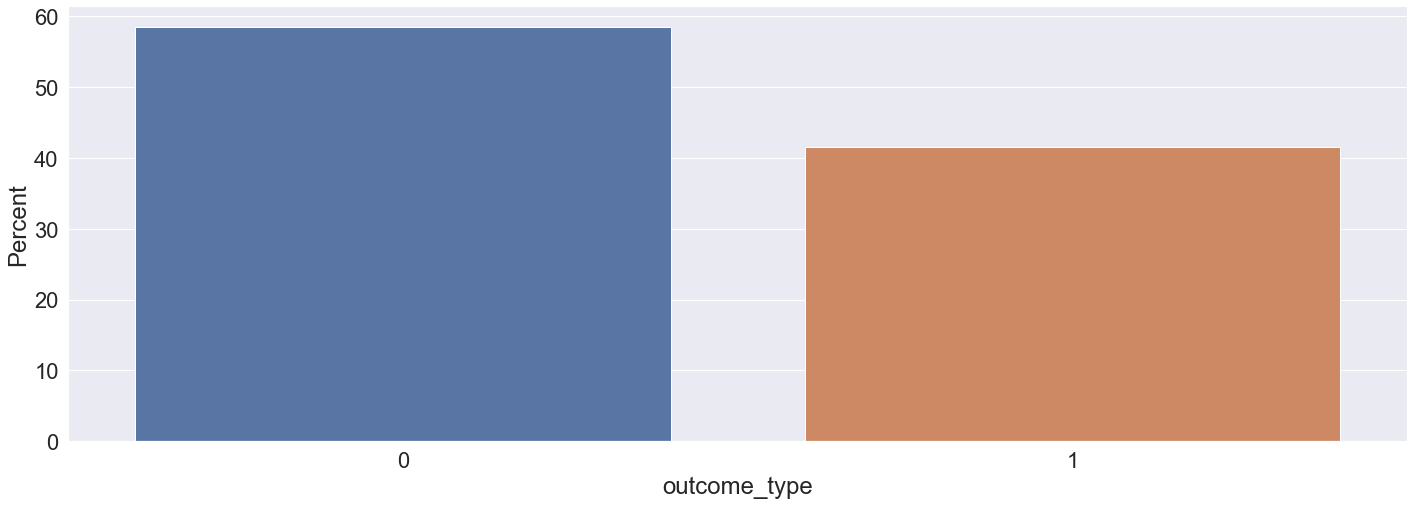

In [531]:
plt.figure(figsize=(24, 8))
sns.set(font_scale=2)
ax = sns.barplot(x="outcome_type", y="outcome_type", data=df_train_scaled, estimator=lambda x: len(x) / len(df_train_scaled) * 100)
ax.set(ylabel="Percent")
plt.show()

In [532]:
print('baseline accuracy in percent')
np.round(len(df_train_scaled[df_train_scaled['outcome_type']==0])/len(df_train_scaled),2)*100

baseline accuracy in percent


57.99999999999999

Before we start the training, we need a baseline against which we can measure our model's performance. A quick and easy solution is to take the percentage of the majority and use this is the baseline. The logic behind this is that a lazy classifier, which only predicts the majority class, would have an accuracy equal to the percentage of datapoints of the majority class.

In this case the baseline is around 58%.

In [533]:
X_train_final = df_train_scaled.drop('outcome_type', axis=1)
y_train_final = df_train_scaled['outcome_type']

X_test_final = df_test_scaled.drop('outcome_type', axis=1)
y_test_final = df_test_scaled['outcome_type']

In [534]:
round(len(X_train_final)/(len(X_train_final)+len(X_test_final)),2)

0.81

During the train/test split, you might have noticed that the split was not a perfect 80/20 but more a 82.5/17.5. The reason for this was that we dropped some rows during the outlier detection afterwards, which would have resulted in a split lower than 80/20, if he had indicated this in train/test split. Here you can see that the split before CV is now 81/21, so basically 80/20.

# Hyperparameter Tuning and K-Fold Cross Validation

In [535]:
params_rf = {"n_estimators": [1,10,50,100,200],
              "max_depth": list(range(1, 16))
              }

rf = RandomForestClassifier()
acs = make_scorer(accuracy_score, greater_is_better=True)
bcv = BayesSearchCV(rf, params_rf,cv=3, n_iter=50, random_state=42, verbose=0, n_jobs=1, n_points=50, scoring=acs)

In [536]:
with warnings.catch_warnings():
    #The Bayes Optimizer Library throws some pretty lenghty FutureWarnings during fitting. We will ignore them.
    warnings.filterwarnings("ignore")
    bcv.fit(X_train_final, y_train_final)

In [537]:
np.round(bcv.best_score_,3)*100

71.7

We then set up the parameters for our Random Forest Classifier and use Bayesian Hyperparameter Optimization with 3-Fold Cross Validation to find the best parameters and preliminarily test the model's performance. I prefer Bayesian CV over GridSearch, because it converges on the optimal parameter space much faster as it uses logic to get there, while GridSearch is basically "brute force"

The mean accuracy of our optimized algorithm over all 3 folds is 71.7%, which is higher than our baseline.

In [538]:
rf_best = bcv.best_estimator_
rf_best.fit(X_train_final, y_train_final)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Prediction and Evaluation

In [539]:
y_pred = rf_best.predict(X_test_final)

In [540]:
acc = accuracy_score(y_test_final, y_pred)
print('test data accuracy:', np.round(acc,4)*100,'%')

test data accuracy: 70.99 %


After training on the entire training data set on optimized hyperparameters, we then predict on the never before seen test data and achieve an almost equal accuracy of 71%, which also indicates no over nor underfitting.

In [541]:
pd.crosstab(y_pred, y_test_final, 
            rownames=['predicted'], 
            colnames=['actual'], margins=False, margins_name="Total")

actual,0,1
predicted,,
0,5958,1940
1,2104,3939


Looking at the confusion matrix, we also notice that false positives and negatives are almost the same in absolute terms.

# Feature Importance

Text(0.5, 0, 'Random Forest Feature Importance')

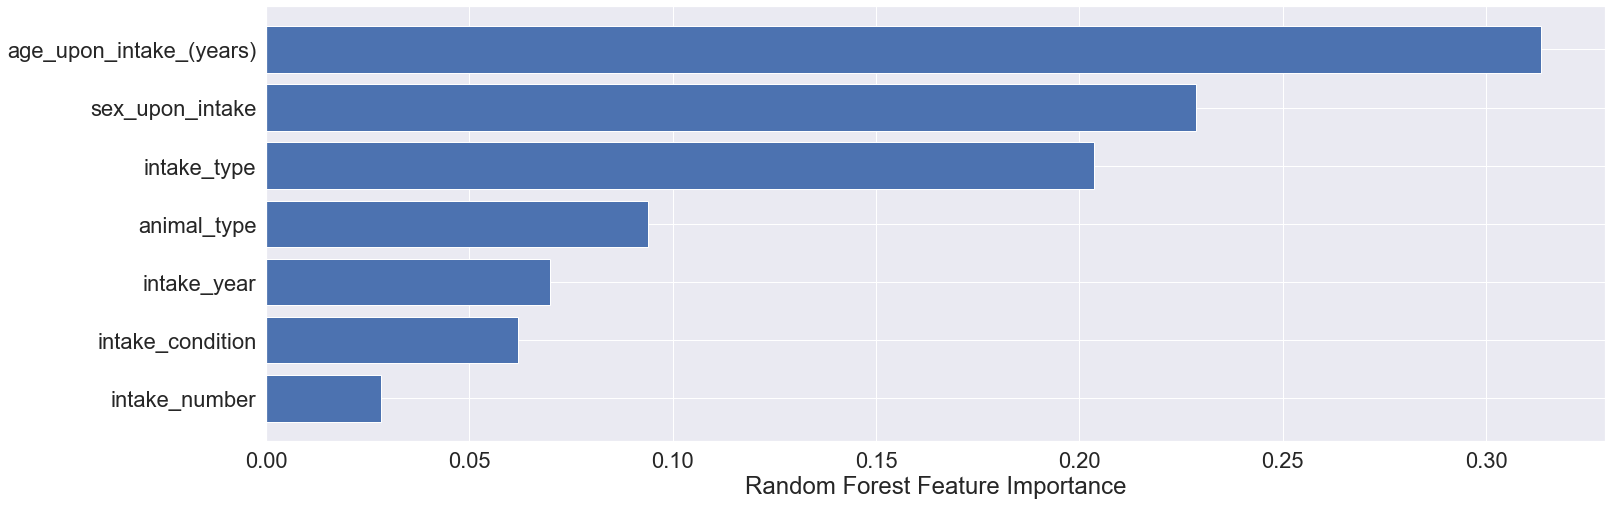

In [542]:
sorted_idx = rf_best.feature_importances_.argsort()
plt.figure(figsize=(24, 8))
plt.barh(X_train_final.columns[sorted_idx], rf_best.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [543]:
abc = list(zip(X_train_final.columns[sorted_idx], np.round(rf_best.feature_importances_[sorted_idx],2)))

In [544]:
sorted(abc, key=lambda x: x[1])

[('intake_number', 0.03),
 ('intake_condition', 0.06),
 ('intake_year', 0.07),
 ('animal_type', 0.09),
 ('intake_type', 0.2),
 ('sex_upon_intake', 0.23),
 ('age_upon_intake_(years)', 0.31)]

Here are the feature Importance scores

- age_upon_intake_(years): 0.31
- sex_upon_intake: 0.23
- intake_type: 0.2
- animal_type: 0.09
- intake_condition: 0.07
- intake_year: 0.06
- intake_number: 0.03